In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import pathlib
from tqdm.auto import tqdm
from IPython.display import HTML

import acoustic_no.cno.cno_layers as cno_layers
from acoustic_no.cno.cno_model import CNOModel
from acoustic_no.data import ShuffledAcousticDataset

In [2]:
# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
cno_activation = cno_layers.ActivationLayer("relu")

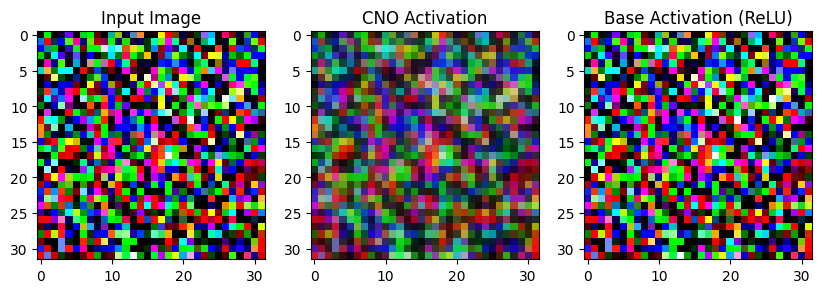

In [4]:
x = torch.randn(1, 3, 32, 32, device=device)  # Create a random input tensor
# Clamp the input to the range [0, 1]
x = torch.clamp(x, 0, 1)
x_cno = cno_activation(x)  # Apply the activation layer
x_base = F.relu(x)  # Apply the base activation function
# Show the difference
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(x[0].cpu().detach().numpy().transpose(1, 2, 0))  # Convert to numpy and transpose for plotting
ax[0].set_title("Input Image")
ax[1].imshow(x_cno[0].cpu().detach().numpy().transpose(1, 2, 0))  # Convert to numpy and transpose for plotting
ax[1].set_title("CNO Activation")
ax[2].imshow(x_base[0].cpu().detach().numpy().transpose(1, 2, 0))  # Convert to numpy and transpose for plotting
ax[2].set_title("Base Activation (ReLU)")
plt.show()  # Display the images

# Load Dataset

In [5]:
# Load the dataset
dataset = ShuffledAcousticDataset(
    dataset_dir=pathlib.Path("/opt/dlami/nvme/acoustic-no/training/processed"),
)
print(f"Dataset size: {len(dataset)}")

Dataset size: 8192


In [6]:
depth = dataset.depth
depth

64

In [7]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
train_dataset = Subset(dataset, range(train_size))
val_dataset = Subset(dataset, range(train_size, len(dataset)))
# Use a random subset of the dataset for training
N_TRAIN, N_VAL = 4096, 16
train_dataset = Subset(train_dataset, range(N_TRAIN))
val_dataset = Subset(val_dataset, range(N_VAL))
# Create a data loader
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=10,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=10,
)

# A Simple CNO Model

In [8]:
model = CNOModel(
    input_channels=depth * 3 + 1,
    hidden_channels=[64, 64],
    layer_sizes=[2, 2],
    output_channels=depth
)
model.to(device)  # Move the model to the appropriate device
model

CNOModel(
  (lifting): Conv2d(193, 64, kernel_size=(1, 1), stride=(1, 1))
  (downsample_blocks): ModuleList(
    (0): DownsampleBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ActivationLayer(
        (activation): ReLU()
      )
    )
  )
  (upsample_blocks): ModuleList(
    (0): UpsampleBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ActivationLayer(
        (activation): ReLU()
      )
    )
  )
  (cno_layers): ModuleList(
    (0-1): 2 x CNOLayer(
      (residual_blocks): ModuleList(
        (0-1): 2 x ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ActivationLayer(
            (activation): ReLU()
          )
        )
      )
      (identity_block): IdentityBlock(
        (conv): Conv2d(64, 64, kernel_size=

In [9]:
# Initialize training parameters
num_epochs = 8
learning_rate = 0.001
criterion = nn.MSELoss()  # Use Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, targets = batch["x"], batch["y"]  # Get inputs and targets from the batch
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()
        
        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / (i + 1):.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/8], Step [10/64], Loss: 47.1354
Epoch [1/8], Step [20/64], Loss: 45.1440
Epoch [1/8], Step [30/64], Loss: 43.6674
Epoch [1/8], Step [40/64], Loss: 41.0429
Epoch [1/8], Step [50/64], Loss: 39.5954
Epoch [1/8], Step [60/64], Loss: 37.8405
Epoch [1/8], Average Loss: 37.2538
Epoch [2/8], Step [10/64], Loss: 26.6182
Epoch [2/8], Step [20/64], Loss: 25.4779
Epoch [2/8], Step [30/64], Loss: 24.4508
Epoch [2/8], Step [40/64], Loss: 22.7566
Epoch [2/8], Step [50/64], Loss: 21.7461
Epoch [2/8], Step [60/64], Loss: 20.9217
Epoch [2/8], Average Loss: 20.6423
Epoch [3/8], Step [10/64], Loss: 15.7010
Epoch [3/8], Step [20/64], Loss: 15.3102
Epoch [3/8], Step [30/64], Loss: 15.0123
Epoch [3/8], Step [40/64], Loss: 14.3422
Epoch [3/8], Step [50/64], Loss: 14.0702
Epoch [3/8], Step [60/64], Loss: 13.7521
Epoch [3/8], Average Loss: 13.6560
Epoch [4/8], Step [10/64], Loss: 11.7446
Epoch [4/8], Step [20/64], Loss: 11.6031
Epoch [4/8], Step [30/64], Loss: 11.6130
Epoch [4/8], Step [40/64], Loss: 1

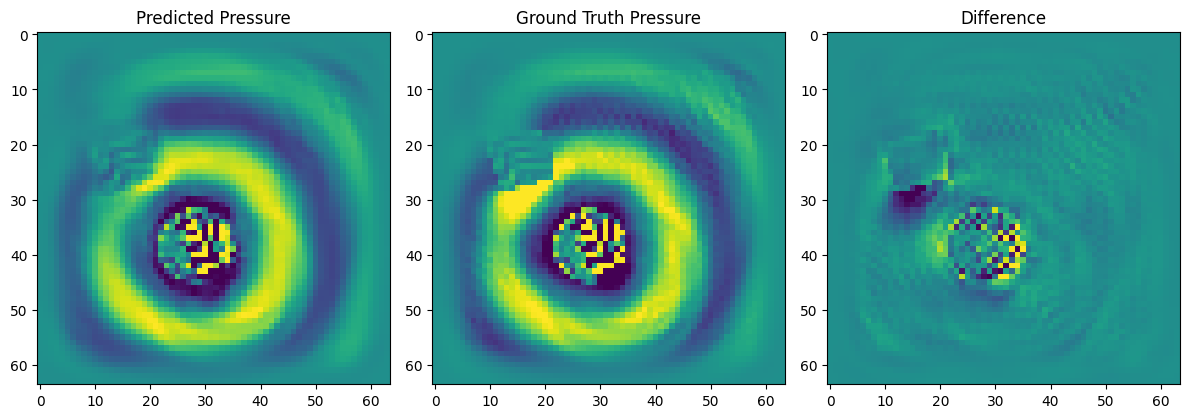

In [10]:
# Inference
model.eval()
eval_data = val_dataset[0]
x = eval_data["x"]
p = eval_data["y"]
v = eval_data["v"]
a = eval_data["a"]
with torch.no_grad():
    pred = model(x.unsqueeze(0).to(device))

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(pred[0, -1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[0].set_title("Predicted Pressure")
ax[1].imshow(p[-1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[1].set_title("Ground Truth Pressure")
ax[2].imshow(pred[0, -1].cpu().numpy() - p[-1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[2].set_title("Difference")
plt.tight_layout()
plt.show()


Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


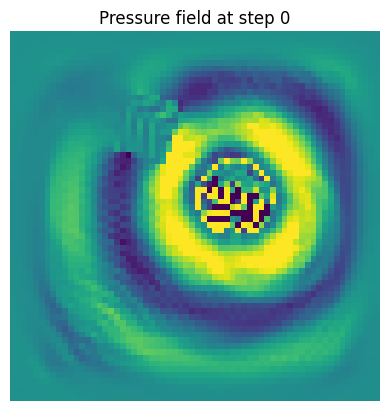

In [11]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=depth, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        p.cpu()[frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == depth - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(depth),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())

Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


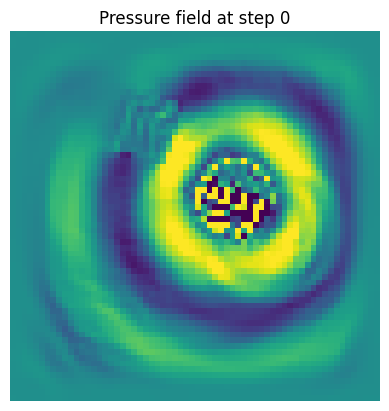

In [12]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=depth, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        pred.cpu()[0, frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == depth - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(depth),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pred_pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())

In [13]:
# Benchmark the model performance on the validation set with MSE loss.
model.eval()
mse_loss = torch.nn.MSELoss()
val_loss = 0.0
with torch.no_grad():
    for data in val_loader:
        x = data["x"].to(device)
        y = data["y"].to(device)
        pred = model(x)
        loss = mse_loss(pred, y)
        val_loss += loss.item()
val_loss /= len(val_loader)
print(f"Validation loss: {val_loss:.4f}")

Validation loss: 5.3002
